In [37]:
# import libraries
import pandas as pd
import datetime
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or retina
%matplotlib inline

sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)

In [231]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [210109, 210116, 210123, 210130,
             210206, 210213, 210220, 210227, 
             210306, 210313, 210320, 210327,
             210403]
turnstiles_df = get_data(week_nums)

In [ ]:
#converting the above data into one big csv file
#turnstiles_df.to_csv('mta_data_all.csv', header = False, index = False)

In [4]:
# SQLAlchemy connecting mta.db with python
#engine = create_engine("sqlite:///mta.db")
#all_data = pd.read_sql('SELECT * FROM mta_data;', engine)
#all_data.head()

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/28/2020,03:00:00,REGULAR,7495312,2551701
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/28/2020,07:00:00,REGULAR,7495318,2551711
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/28/2020,11:00:00,REGULAR,7495333,2551756
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/28/2020,15:00:00,REGULAR,7495436,2551802
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/28/2020,19:00:00,REGULAR,7495596,2551834


In [155]:
turnstiles_df["DATE"]

0         01/02/2021
1         01/02/2021
2         01/02/2021
3         01/02/2021
4         01/02/2021
             ...    
209063    04/02/2021
209064    04/02/2021
209065    04/02/2021
209066    04/02/2021
209067    04/02/2021
Name: DATE, Length: 2718462, dtype: object

In [232]:
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME,
                                            format="%m/%d/%Y %H:%M:%S")
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,03:00:00,REGULAR,7511653,2558871,2021-01-02 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,07:00:00,REGULAR,7511655,2558877,2021-01-02 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,11:00:00,REGULAR,7511677,2558930,2021-01-02 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,15:00:00,REGULAR,7511766,2558968,2021-01-02 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,19:00:00,REGULAR,7511912,2558999,2021-01-02 19:00:00


In [233]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
1829770,R145,R032,00-00-02,TIMES SQ-42 ST,2021-01-31 23:00:00,2
1829795,R145,R032,00-00-02,TIMES SQ-42 ST,2021-02-04 23:00:00,2
1829797,R145,R032,00-00-02,TIMES SQ-42 ST,2021-02-05 07:00:00,2
2376507,R417,R222,00-03-01,PARKCHESTER,2021-03-26 05:00:00,2
2373778,R417,R222,00-00-01,PARKCHESTER,2021-03-26 05:00:00,2


In [234]:
turnstiles_df.DESC.value_counts() #check number of RECOVR AUD

REGULAR       2707290
RECOVR AUD      11172
Name: DESC, dtype: int64

In [235]:
# Get rid of the duplicate entry
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [236]:
turnstiles_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME
209067,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/02/2021,21:00:00,5554,544,2021-04-02 21:00:00
209066,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/02/2021,17:00:00,5554,544,2021-04-02 17:00:00
209065,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/02/2021,13:00:00,5554,544,2021-04-02 13:00:00
209064,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/02/2021,09:00:00,5554,544,2021-04-02 09:00:00
209063,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/02/2021,05:00:00,5554,544,2021-04-02 05:00:00


In [246]:
turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())
turnstiles_daily

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,01/02/2021,7511996
1,A002,R051,02-00-00,59 ST,01/03/2021,7512214
2,A002,R051,02-00-00,59 ST,01/04/2021,7512754
3,A002,R051,02-00-00,59 ST,01/05/2021,7513300
4,A002,R051,02-00-00,59 ST,01/06/2021,7513790
...,...,...,...,...,...,...
454004,TRAM2,R469,00-05-01,RIT-ROOSEVELT,03/29/2021,5554
454005,TRAM2,R469,00-05-01,RIT-ROOSEVELT,03/30/2021,5554
454006,TRAM2,R469,00-05-01,RIT-ROOSEVELT,03/31/2021,5554
454007,TRAM2,R469,00-05-01,RIT-ROOSEVELT,04/01/2021,5554


In [247]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                    .groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES"]]
                                                    .shift(1))
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,01/02/2021,7511996,NaN,NaN
1,A002,R051,02-00-00,59 ST,01/03/2021,7512214,01/02/2021,7511996.0
2,A002,R051,02-00-00,59 ST,01/04/2021,7512754,01/03/2021,7512214.0
3,A002,R051,02-00-00,59 ST,01/05/2021,7513300,01/04/2021,7512754.0
4,A002,R051,02-00-00,59 ST,01/06/2021,7513790,01/05/2021,7513300.0


In [163]:
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [164]:
(turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A   UNIT  SCP       STATION        
A002  R051  02-03-02  59 ST               1
A011  R080  01-03-00  57 ST-7 AV         90
            01-03-01  57 ST-7 AV          1
A025  R023  01-06-00  34 ST-HERALD SQ     1
A031  R083  00-00-01  23 ST               1
                                         ..
R622  R123  00-00-00  FRANKLIN AV        89
R624  R124  00-00-02  KINGSTON AV         1
R627  R063  00-03-02  SUTTER AV-RUTLD     1
R730  R431  00-00-04  EASTCHSTER/DYRE    90
S101  R070  00-00-04  ST. GEORGE          1
Length: 205, dtype: int64

In [165]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        print(f'entries: {row["ENTRIES"]} <-- {row["PREV_ENTRIES"]}')
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

entries: 238 <-- 6641395.0
entries: 52806 <-- 17116894.0
entries: 117 <-- 11715665.0
entries: 198 <-- 5102094.0
entries: 327680 <-- 185586773.0
entries: 169 <-- 2172444.0
entries: 127 <-- 1657032.0
entries: 80 <-- 1640812.0
entries: 327834 <-- 2642486.0
entries: 16796392 <-- 123975.0
entries: 453044031 <-- 1779426.0
entries: 262272 <-- 2255518.0
entries: 393225 <-- 7714275.0
entries: 57 <-- 2028804.0
entries: 16712028 <-- 6294957.0
entries: 177 <-- 16712669.0
entries: 262144 <-- 33554713.0
entries: 394 <-- 2773389.0
entries: 106 <-- 67960951.0
entries: 147 <-- 11567738.0
entries: 1950 <-- 13809288.0
entries: 54 <-- 7903750.0
entries: 2293788 <-- 4259642.0
entries: 471 <-- 1377273.0
entries: 248 <-- 827160459.0
entries: 0 <-- 67108864.0
entries: 47 <-- 2514854.0
entries: 1376376 <-- 8181460.0
entries: 420 <-- 4343900.0
entries: 262297 <-- 1566066.0
entries: 23157312 <-- 1627480738.0
entries: 35 <-- 10195434.0
entries: 702 <-- 3651815.0
entries: 697 <-- 13204039.0
entries: 262152 <-- 671

In [166]:
turnstiles_daily.DAILY_ENTRIES.describe()

count    448972.000000
mean        350.307641
std        6024.213610
min           0.000000
25%          51.000000
50%         189.000000
75%         398.000000
max      984026.000000
Name: DAILY_ENTRIES, dtype: float64

In [167]:
# daily entries for each station
station_daily = turnstiles_daily.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily

,STATION,DATE,DAILY_ENTRIES
0,1 AV,01/03/2021,2547.0
1,1 AV,01/04/2021,5303.0
2,1 AV,01/05/2021,5468.0
3,1 AV,01/06/2021,5603.0
4,1 AV,01/07/2021,5665.0
...,...,...,...
34004,ZEREGA AV,03/29/2021,1012.0
34005,ZEREGA AV,03/30/2021,1093.0
34006,ZEREGA AV,03/31/2021,1011.0
34007,ZEREGA AV,04/01/2021,1051.0


In [35]:
# total ridership for unique station
station_total = station_daily.groupby('STATION')['DAILY_ENTRIES'].sum() \
    .reset_index() \
    .sort_values('DAILY_ENTRIES', ascending=False)
station_total

,STATION,DAILY_ENTRIES
59,34 ST-HERALD SQ,3004542.0
61,34 ST-PENN STA,2889380.0
0,1 AV,2688395.0
233,GRD CNTRL-42 ST,2563142.0
352,TIMES SQ-42 ST,2398335.0
...,...,...
332,ROCKAWAY PARK B,19737.0
148,BEACH 98 ST,9852.0
162,BROAD CHANNEL,7612.0
300,NEWARK HM HE,4800.0


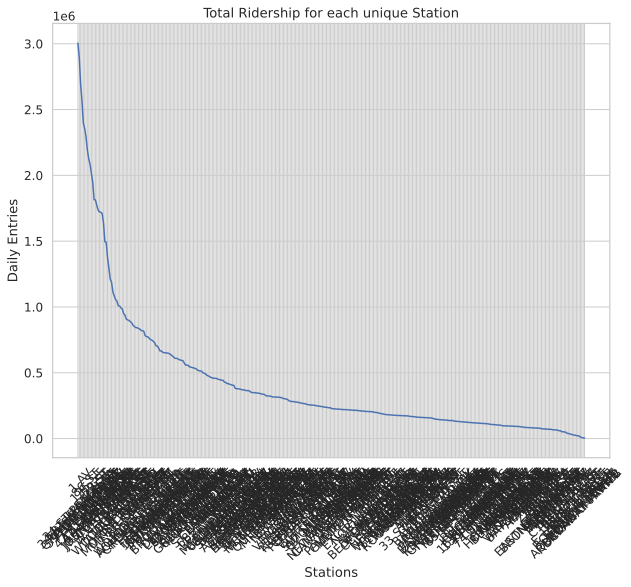

In [41]:
plt.figure(figsize=(10,8))
plt.plot(station_total["STATION"], station_total["DAILY_ENTRIES"])
plt.xlabel('Stations')
plt.ylabel('Daily Entries')
plt.xticks(rotation=45)
plt.title('Total Ridership for each unique Station');

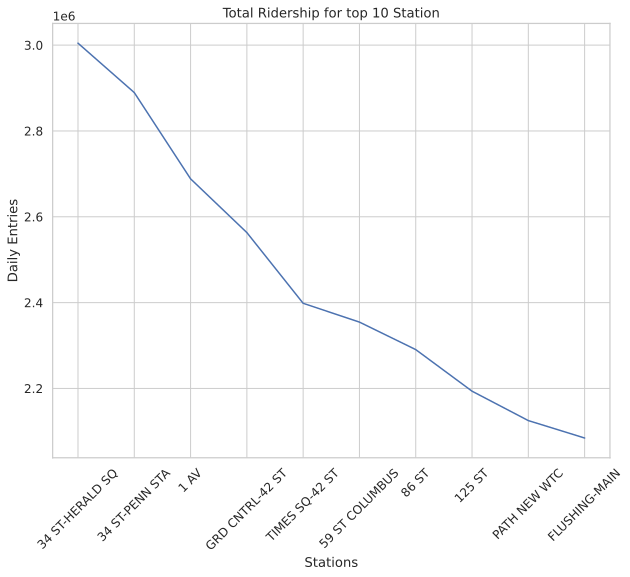

In [40]:
plt.figure(figsize=(10,8))
plt.plot(station_total["STATION"][0:10], station_total["DAILY_ENTRIES"][0:10])
plt.xlabel('Stations')
plt.ylabel('Daily Entries')
plt.xticks(rotation=45)
plt.title('Total Ridership for top 10 Station');

In [ ]:
###########################################################

In [248]:
turnstiles_df.sort_values(by = ["DATE", "DATE_TIME"], ascending=[True, True], inplace=True)
turnstiles_df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME
210124,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,01/02/2021,00:00:00,5554,541,2021-01-02 00:00:00
210082,TRAM2,R469,00-05-00,RIT-ROOSEVELT,R,RIT,01/02/2021,00:00:00,3191,62,2021-01-02 00:00:00
210040,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,01/02/2021,00:00:00,3133524,397443,2021-01-02 00:00:00
209998,TRAM2,R469,00-03-00,RIT-ROOSEVELT,R,RIT,01/02/2021,00:00:00,753040,30728,2021-01-02 00:00:00
209956,TRAM2,R469,00-00-01,RIT-ROOSEVELT,R,RIT,01/02/2021,00:00:00,3626090,47921,2021-01-02 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
119019,PTH03,R552,00-00-0A,JOURNAL SQUARE,1,PTH,04/02/2021,23:56:54,65685,961453,2021-04-02 23:56:54
122522,PTH09,R548,00-00-01,CHRISTOPHER ST,1,PTH,04/02/2021,23:57:14,684655,557364,2021-04-02 23:57:14
122762,PTH10,R547,00-00-03,9TH STREET,1,PTH,04/02/2021,23:58:16,50423,172030,2021-04-02 23:58:16
119768,PTH04,R551,00-00-03,GROVE STREET,1,PTH,04/02/2021,23:59:09,10526,80481,2021-04-02 23:59:09


In [249]:
def commute_interval(DATE_TIME):
    if DATE_TIME.hour >=0 and DATE_TIME.hour < 4:
        return '00:00-04:00'
    elif DATE_TIME.hour >= 4 and DATE_TIME.hour < 8:
        return '04:00-08:00'
    elif DATE_TIME.hour >= 8 and DATE_TIME.hour < 12:
        return '08:00-12:00'
    elif DATE_TIME.hour >= 12 and DATE_TIME.hour < 16:
        return '12:00-16:00'
    elif DATE_TIME.hour >= 16 and DATE_TIME.hour < 20:
        return '16:00-20:00'
    elif DATE_TIME.hour >= 20 and DATE_TIME.hour < 24:
        return '20:00-24:00'
    else:
        return 'GO HOME'

In [250]:
# .apply the created function above
turnstiles_df['INTERVAL'] = turnstiles_df.DATE_TIME.apply(commute_interval)

In [251]:
turnstiles_df.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,INTERVAL
210124,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,01/02/2021,00:00:00,5554,541,2021-01-02,00:00-04:00
210082,TRAM2,R469,00-05-00,RIT-ROOSEVELT,R,RIT,01/02/2021,00:00:00,3191,62,2021-01-02,00:00-04:00
210040,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,01/02/2021,00:00:00,3133524,397443,2021-01-02,00:00-04:00
209998,TRAM2,R469,00-03-00,RIT-ROOSEVELT,R,RIT,01/02/2021,00:00:00,753040,30728,2021-01-02,00:00-04:00
209956,TRAM2,R469,00-00-01,RIT-ROOSEVELT,R,RIT,01/02/2021,00:00:00,3626090,47921,2021-01-02,00:00-04:00
209914,TRAM2,R469,00-00-00,RIT-ROOSEVELT,R,RIT,01/02/2021,00:00:00,717912,16864,2021-01-02,00:00-04:00
209872,TRAM1,R468,00-05-00,RIT-MANHATTAN,R,RIT,01/02/2021,00:00:00,490,0,2021-01-02,00:00-04:00
209830,TRAM1,R468,00-00-02,RIT-MANHATTAN,R,RIT,01/02/2021,00:00:00,307966,5837,2021-01-02,00:00-04:00
209788,TRAM1,R468,00-00-01,RIT-MANHATTAN,R,RIT,01/02/2021,00:00:00,208232,3683,2021-01-02,00:00-04:00
209746,TRAM1,R468,00-00-00,RIT-MANHATTAN,R,RIT,01/02/2021,00:00:00,898665,19024,2021-01-02,00:00-04:00


In [259]:
turnstiles_interval = (turnstiles_df
                        .groupby(["STATION", "DATE", "INTERVAL"],as_index=False)
                        .ENTRIES.first())

In [260]:
turnstiles_interval

,STATION,DATE,INTERVAL,ENTRIES
0,1 AV,01/02/2021,00:00-04:00,181468
1,1 AV,01/02/2021,04:00-08:00,181475
2,1 AV,01/02/2021,08:00-12:00,181552
3,1 AV,01/02/2021,12:00-16:00,181703
4,1 AV,01/02/2021,16:00-20:00,181906
...,...,...,...,...
206017,ZEREGA AV,04/02/2021,04:00-08:00,39
206018,ZEREGA AV,04/02/2021,08:00-12:00,39
206019,ZEREGA AV,04/02/2021,12:00-16:00,39
206020,ZEREGA AV,04/02/2021,16:00-20:00,39


,STATION,DATE,INTERVAL,ENTRIES,PREV_DATE,PREV_ENTRIES
0,1 AV,01/02/2021,00:00-04:00,181468,NaN,NaN
1,1 AV,01/02/2021,04:00-08:00,181475,NaN,NaN
2,1 AV,01/02/2021,08:00-12:00,181552,NaN,NaN
3,1 AV,01/02/2021,12:00-16:00,181703,NaN,NaN
4,1 AV,01/02/2021,16:00-20:00,181906,NaN,NaN


0              NaN
1         181468.0
2         181475.0
3         181552.0
4         181703.0
            ...   
206017        39.0
206018        39.0
206019        39.0
206020        39.0
206021        39.0
Name: ENTRIES, Length: 206022, dtype: float64

In [132]:
turnstiles_interval.dropna(subset=["PREV_DATE", "PREV_ENTRIES"], axis=0, inplace=True)

In [133]:
turnstiles_interval.head(15)

,STATION,DATE,INTERVAL,ENTRIES,PREV_DATE,PREV_ENTRIES
6,1 AV,01/03/2021,00:00-04:00,182085,01/02/2021,181468.0
7,1 AV,01/03/2021,04:00-08:00,182089,01/02/2021,181475.0
8,1 AV,01/03/2021,08:00-12:00,182142,01/02/2021,181552.0
9,1 AV,01/03/2021,12:00-16:00,182248,01/02/2021,181703.0
10,1 AV,01/03/2021,16:00-20:00,182400,01/02/2021,181906.0
11,1 AV,01/03/2021,20:00-24:00,182474,01/02/2021,182054.0
12,1 AV,01/04/2021,00:00-04:00,182506,01/03/2021,182085.0
13,1 AV,01/04/2021,04:00-08:00,182524,01/03/2021,182089.0
14,1 AV,01/04/2021,08:00-12:00,182668,01/03/2021,182142.0
15,1 AV,01/04/2021,12:00-16:00,182879,01/03/2021,182248.0


In [99]:
(turnstiles_interval["ENTRIES"] - turnstiles_interval["PREV_ENTRIES"]).describe()

count    2.060160e+05
mean    -5.290482e+00
std      3.854740e+07
min     -1.954204e+09
25%      5.000000e+00
50%      2.010000e+02
75%      4.700000e+02
max      1.954204e+09
dtype: float64